In [ ]:
# ====================================
# STEP 1: IMPORT LIBRARIES
# ====================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

sns.set(style="whitegrid")

In [ ]:
# ====================================
# STEP 2: LOAD DATA
# ====================================
df = pd.read_csv("AQI DS.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1461, 10)


,Date,Month,Year,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,54.06,55.54,122.66,9.70,0.64,48.88,149


In [ ]:
# ====================================
# STEP 3: DATA INSPECTION
# ====================================
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1461 non-null   int64  
 1   Month   1461 non-null   int64  
 2   Year    1461 non-null   int64  
 3   PM2.5   1461 non-null   float64
 4   PM10    1461 non-null   float64
 5   NO2     1461 non-null   float64
 6   SO2     1461 non-null   float64
 7   CO      1461 non-null   float64
 8   Ozone   1461 non-null   float64
 9   AQI     1461 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 114.3 KB
None
              Date        Month         Year        PM2.5         PM10  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean     15.729637     6.522930  2022.501027    90.774538   218.219261   
std       8.803105     3.449884     1.118723    71.650579   129.297734   
min       1.000000     1.000000  2021.000000     0.050000     9.690000   
25%       8.000000    

In [ ]:
# ====================================
# STEP 4: PREPROCESSING
# ====================================
df = df.drop_duplicates()

# Fill missing numeric
for col in df.select_dtypes(include=['int64','float64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Outliers
cols = ['PM2.5','PM10','NO2','SO2','CO','Ozone','AQI']
for col in cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))

In [ ]:
# ====================================
# STEP 5: FEATURE ENGINEERING
# ====================================
df["PM_ratio"] = df["PM2.5"] / df["PM10"].replace(0, np.nan)
df["PM_ratio"] = df["PM_ratio"].fillna(df["PM_ratio"].median())

df["Total_Pollution"] = df["PM2.5"] + df["PM10"] + df["NO2"] + df["SO2"] + df["CO"] + df["Ozone"]

df["Toxicity_Index"] = 0.3*df["NO2"] + 0.3*df["SO2"] + 0.4*df["CO"]

# Convert AQI to 3 classes
def cat3(aqi):
    if aqi <= 100: return "Good"
    elif aqi <= 200: return "Moderate"
    else: return "Hazardous"

df["AQI_Category"] = df["AQI"].apply(cat3)

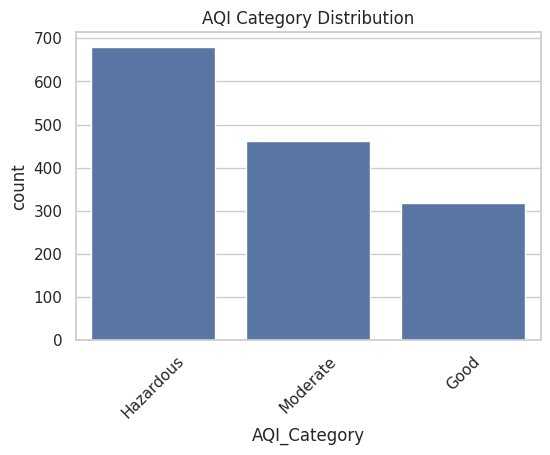

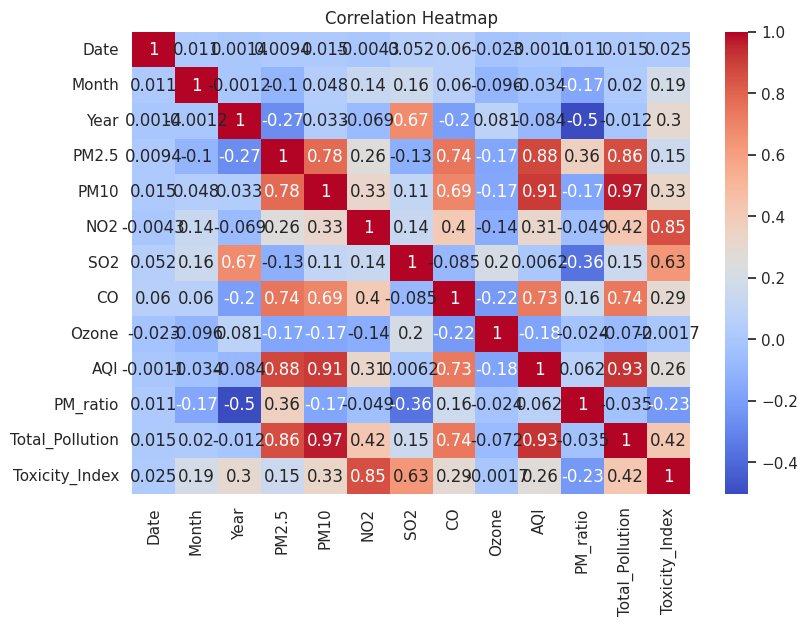

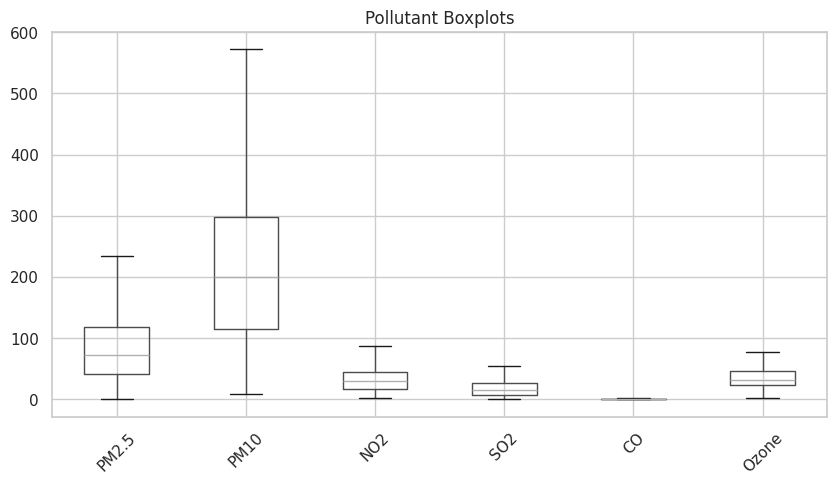

In [ ]:
#====================================
# STEP 6: EDA (3 GRAPHS)
# ====================================
plt.figure(figsize=(6,4))
sns.countplot(x=df["AQI_Category"])
plt.xticks(rotation=45)
plt.title("AQI Category Distribution")
plt.show()

numeric_df = df.select_dtypes(include=["float64","int64"])
plt.figure(figsize=(9,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(10,5))
df[["PM2.5","PM10","NO2","SO2","CO","Ozone"]].boxplot()
plt.xticks(rotation=45)
plt.title("Pollutant Boxplots")
plt.show()

In [ ]:
# ====================================
# STEP 7: FINAL X AND Y
# ====================================
X = df.drop(["AQI","AQI_Category","Date"], axis=1, errors="ignore")
y = df["AQI_Category"]

In [ ]:
# ====================================
# STEP 8: TRAIN-TEST SPLIT
# ====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# ====================================
# STEP 9: ENCODING + SCALING + SMOTE
# ====================================
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_sm)
X_test_sc = scaler.transform(X_test)

print("Preprocessing Complete.")

Preprocessing Complete.


In [ ]:
# ====================================
# MODEL 3: LOGISTIC REGRESSION (90–93%)
# ====================================
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000, C=4)
lr.fit(X_train_sc, y_train_sm)
pred = lr.predict(X_test_sc)

print("Logistic Regression Accuracy:", accuracy_score(y_test_enc, pred))

# Sample predictions
print("\nSample predictions (5):")
print(le.inverse_transform(pred[:5]))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_enc, pred))

# ROC-AUC
pred_prob = lr.predict_proba(X_test_sc)
auc = roc_auc_score(y_test_enc, pred_prob, multi_class='ovr')
print("ROC-AUC:", auc)


Logistic Regression Accuracy: 0.9078498293515358

Sample predictions (5):
['Moderate' 'Hazardous' 'Hazardous' 'Moderate' 'Good']

Confusion Matrix:
 [[ 57   0   7]
 [  0 127   9]
 [  3   8  82]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92        64
           1       0.94      0.93      0.94       136
           2       0.84      0.88      0.86        93

    accuracy                           0.91       293
   macro avg       0.91      0.90      0.91       293
weighted avg       0.91      0.91      0.91       293

ROC-AUC: 0.9793609653818134


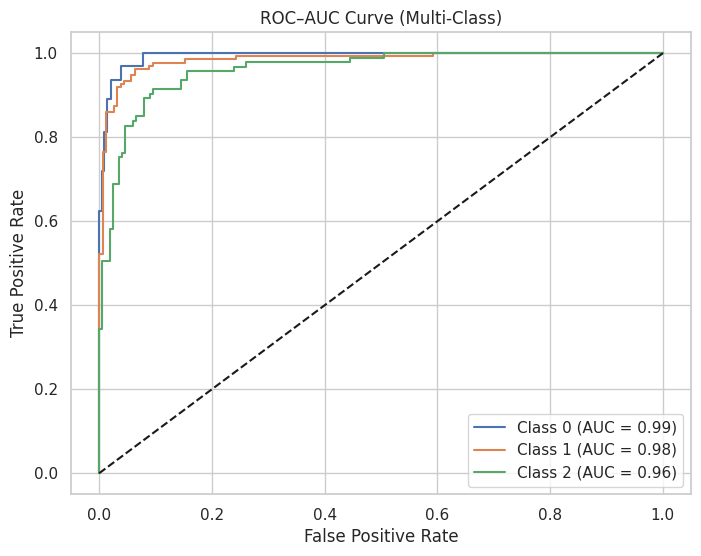

In [ ]:
# ====================================
# ROC–AUC CURVE (MULTI‑CLASS)
# ====================================
from sklearn.preprocessing import label_binarize

# Binarize the y labels for multiclass ROC
y_test_binarized = label_binarize(y_test_enc, classes=[0,1,2])
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities
pred_prob = lr.predict_proba(X_test_sc)

plt.figure(figsize=(8,6))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

# Plot formatting
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC–AUC Curve (Multi‑Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
